                                  Long end Short


Estudo de long end short, para ativos que compõem a carteira B3 que tem ticker BOVA11.

O importante de ser esta carteira, trabalhar com opções (Derivativos), assim diminuindo risco da estratégia.

Foi usado dados MetaTrade5 pois são os que menos apresenta dados nulos e dados faltantes.
 
Este trabalho foi feito em cima da forma clássica:
- Vários períodos de tempo 
- Cointegração 
- Dickey-Fuller
- Resíduos 
Conta com gráfico de fácil visualização 


In [2]:
# importando as bibliotecas 

import datetime as dt
import time
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
from pandas.io.html import read_html
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# URL da página da Wikipedia
page = 'https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa'

# Lê a tabela da página usando pandas
table = pd.read_html(page, attrs={'class': 'wikitable'})

# Obtém a coluna 'Código' e adiciona '.SA' a cada valor
dft = table[0]['Código']
#dft = [i + '.SA' for i in dft]

print(dft)

0     ABEV3
1     AZUL4
2     B3SA3
3     BBAS3
4     BBDC3
      ...  
71    VALE3
72    VIVT4
73    VVAR3
74    WEGE3
75    YDUQ3
Name: Código, Length: 76, dtype: object


In [4]:
# Inicializa a conexão com o terminal MetaTrader 5
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())

# Cria um DataFrame vazio
df = pd.DataFrame()

# Coleta dados de fechamento para cada ticker na lista
for ticker in dft:
    rates = mt5.copy_rates_from_pos(ticker, mt5.TIMEFRAME_D1, 0, 250)
    dfa = pd.DataFrame(rates)
    
    
    if 'close' in dfa.columns:
        df[ticker] = dfa['close']
    else:
        print(f"Este ticker '{ticker}' não foi localizado.")

# Coleta dados de fechamento para o ticker 'ITSA4' para parametros
rates = mt5.copy_rates_from_pos('ITSA4', mt5.TIMEFRAME_D1, 0, 250)
dfa = pd.DataFrame(rates)
dfa['time'] = pd.to_datetime(dfa['time'], unit='s')
df.set_index(dfa['time'], inplace=True)

# Exibe as primeiras linhas do DataFrame
print(df.head())

# Encerra a conexão com o MetaTrader 5
mt5.shutdown()

Este ticker 'BRDT3' não foi localizado.
Este ticker 'BRML3' não foi localizado.
Este ticker 'BTOW3' não foi localizado.
Este ticker 'ELET6' não foi localizado.
Este ticker 'GNDI3' não foi localizado.
Este ticker 'HGTX3' não foi localizado.
Este ticker 'IGTA3' não foi localizado.
Este ticker 'LAME4' não foi localizado.
Este ticker 'SULA11' não foi localizado.
Este ticker 'TIMP3' não foi localizado.
Este ticker 'VIVT4' não foi localizado.
Este ticker 'VVAR3' não foi localizado.
            ABEV3  AZUL4  B3SA3  BBAS3  BBDC3  BBDC4  BBSE3  BEEF3  BPAC11  \
time                                                                         
2023-03-14  13.36  12.73  11.09  34.63  11.05  12.59  30.46  10.87   19.12   
2023-03-15  13.43  12.92  11.18  34.67  10.97  12.77  30.09  10.62   19.20   
2023-03-16  13.66  13.36  11.49  35.03  11.18  13.13  30.23  10.46   19.95   
2023-03-17  13.62  12.98  10.94  34.44  11.35  12.58  29.70  10.68   19.52   
2023-03-20  13.52  12.80  10.83  34.24  11.00  12.3

True

In [5]:
# não irei usar yahoo finance pois tem muitos dados nulos 

# URL da página da Wikipedia
#page = 'https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa'

# Lê a tabela da página usando pandas
#table = pd.read_html(page, attrs={'class': 'wikitable'})

# Obtém a coluna 'Código' e adiciona '.SA' a cada valor
#dft = table[0]['Código']
#dft = [i + '.SA' for i in dft]

# Criando um DataFrame vazio para armazenar os preços de fechamento ajustados
#adj_close_df = pd.DataFrame()

# Iterando pelos tickers
#for ticker in dft:
    #try:
        # Obtendo os dados históricos para o ticker
        #data = yf.download(ticker, start='2020-01-01', end='2024-03-04')
        # Selecionando apenas a coluna 'Adj Close'
        #adj_close = data['Adj Close']
        # Adicionando os preços de fechamento ajustados ao DataFrame
       # adj_close_df[ticker] = adj_close
    #except Exception as e:
        #print(f"Erro ao obter dados para o ticker {ticker}: {e}")

# Exibindo o DataFrame com os preços de fechamento ajustados
#print(adj_close_df)



In [6]:
# Excluindo colunas com valores nulos
#adj_close_df = df
#adj_close_df = adj_close_df.dropna(axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-03-14 to 2024-03-14
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ABEV3   250 non-null    float64
 1   AZUL4   250 non-null    float64
 2   B3SA3   250 non-null    float64
 3   BBAS3   250 non-null    float64
 4   BBDC3   250 non-null    float64
 5   BBDC4   250 non-null    float64
 6   BBSE3   250 non-null    float64
 7   BEEF3   250 non-null    float64
 8   BPAC11  250 non-null    float64
 9   BRAP4   250 non-null    float64
 10  BRFS3   250 non-null    float64
 11  BRKM5   250 non-null    float64
 12  BRSR6   250 non-null    float64
 13  CCRO3   250 non-null    float64
 14  CIEL3   250 non-null    float64
 15  CMIG4   250 non-null    float64
 16  COGN3   250 non-null    float64
 17  CPFE3   250 non-null    float64
 18  CRFB3   250 non-null    float64
 19  CSAN3   250 non-null    float64
 20  CSNA3   250 non-null    float64
 21  CVCB3   250 non-null

In [8]:
# criando novas colunas com periodos de tempo 

df120 = df.iloc[-120:]
df140 = df.iloc[-140:]
df160 = df.iloc[-160:]
df180 = df.iloc[-180:]
df200 = df.iloc[-200:]
df220 = df.iloc[-220:]
df250 = df.iloc[-250:]
df.copy()
dfs = [df120,df140,df160,df180,df200,df220,df250]
for i in dfs:
    i.dropna(axis=1,inplace=True)

In [9]:
# cointegração entre duas séries temporais (t1 e t2) utilizando o teste de ADF (Augmented Dickey-Fuller).

def cointegration(t1,t2,df):
    model = OLS(df[t1],df[t2])
    model = model.fit()
    adf = adfuller(model.resid)
    #print('test statistic : {}   ,  p-value : {} \n'.format(adf[0],adf[1]))
    #print('Criticals : {}'.format(adf[4]))
    if adf[1] < 0.05:
        return True
    else:
        return False

In [10]:
# vamos aplicar cointegração em diferentes intervalos de tempo.

def get_pairs(): 
    
    pares= []
    dfs = [df120,df140,df160,df180,df200,df220,df250]
    for ticker1 in dfs[0].columns:
        for ticker2 in dfs[0].columns:
            aux=[]
            if ticker1 == ticker2:
                continue
            for timeframe in dfs:
                c = cointegration(ticker1,ticker2,timeframe)
                aux.append(c)
            #print(ticker1,ticker2,aux)
            if sum(aux) >= 3:
                pares.append('{}x{}'.format(ticker1,ticker2))
    return pares

In [11]:
%%time
p = get_pairs()
print(p)

['ABEV3xB3SA3', 'ABEV3xBBDC4', 'ABEV3xCPFE3', 'ABEV3xCSAN3', 'ABEV3xGOAU4', 'ABEV3xHAPV3', 'ABEV3xRAIL3', 'ABEV3xYDUQ3', 'B3SA3xABEV3', 'B3SA3xBBDC3', 'B3SA3xBBDC4', 'B3SA3xCRFB3', 'B3SA3xYDUQ3', 'BBAS3xECOR3', 'BBDC3xB3SA3', 'BBDC3xBBDC4', 'BBDC3xBRAP4', 'BBDC3xCSAN3', 'BBDC3xFLRY3', 'BBDC3xIRBR3', 'BBDC3xMULT3', 'BBDC3xVALE3', 'BBDC3xYDUQ3', 'BBDC4xABEV3', 'BBDC4xB3SA3', 'BBDC4xBBDC3', 'BBDC4xBRAP4', 'BBDC4xEGIE3', 'BBDC4xFLRY3', 'BBDC4xIRBR3', 'BBDC4xMULT3', 'BBDC4xRADL3', 'BBDC4xVALE3', 'BBDC4xYDUQ3', 'BBSE3xENBR3', 'BBSE3xPETR3', 'BPAC11xCRFB3', 'BPAC11xELET3', 'BPAC11xENGI11', 'BRAP4xBBDC3', 'BRAP4xBBDC4', 'BRAP4xFLRY3', 'BRAP4xIRBR3', 'BRAP4xPCAR3', 'BRAP4xVALE3', 'BRKM5xHYPE3', 'BRSR6xCOGN3', 'CCRO3xCRFB3', 'CCRO3xENGI11', 'CCRO3xTAEE11', 'CCRO3xYDUQ3', 'CIEL3xUSIM5', 'CMIG4xKLBN11', 'CMIG4xRADL3', 'CMIG4xRAIL3', 'COGN3xBRSR6', 'COGN3xCSAN3', 'CPFE3xABEV3', 'CPFE3xCSAN3', 'CPFE3xEQTL3', 'CPFE3xTAEE11', 'CPFE3xVALE3', 'CRFB3xB3SA3', 'CRFB3xBPAC11', 'CRFB3xCCRO3', 'CRFB3xCVCB3', 

In [12]:
# resíduos dos pares
 
def get_resid(par):
    t1 = df[par.split('x')[0]]
    t2 = df[par.split('x')[1]]
    model = OLS(t1,t2)
    model = model.fit()
    return model.resid

In [13]:
#  cointegração entre os ativos e intervalo tempo

def cointegration_wtimes(ticker1,ticker2):
    l = [120,140,160,180,200,220,250]
    aux = {}
    for i in range(len(dfs)):
        co = cointegration(ticker1,ticker2,dfs[i])
        aux[l[i]] = co
    return aux


In [14]:
# definindo limite superior e inferior 

def entradas(par):
    r = get_resid(par)
    upper_limit = 2 * r.std()
    lower_limit = -2 * r.std()
    if r.iloc[-1] > upper_limit or r.iloc[-1] < lower_limit:
        return par
    else:
        return False

# Crie uma lista para armazenar os pares de entrada válidos
lista_entradas = []
for par in p:
    a = entradas(par)
    if a:
        lista_entradas.append(a)

print(lista_entradas)

['CRFB3xEMBR3', 'EMBR3xCRFB3']


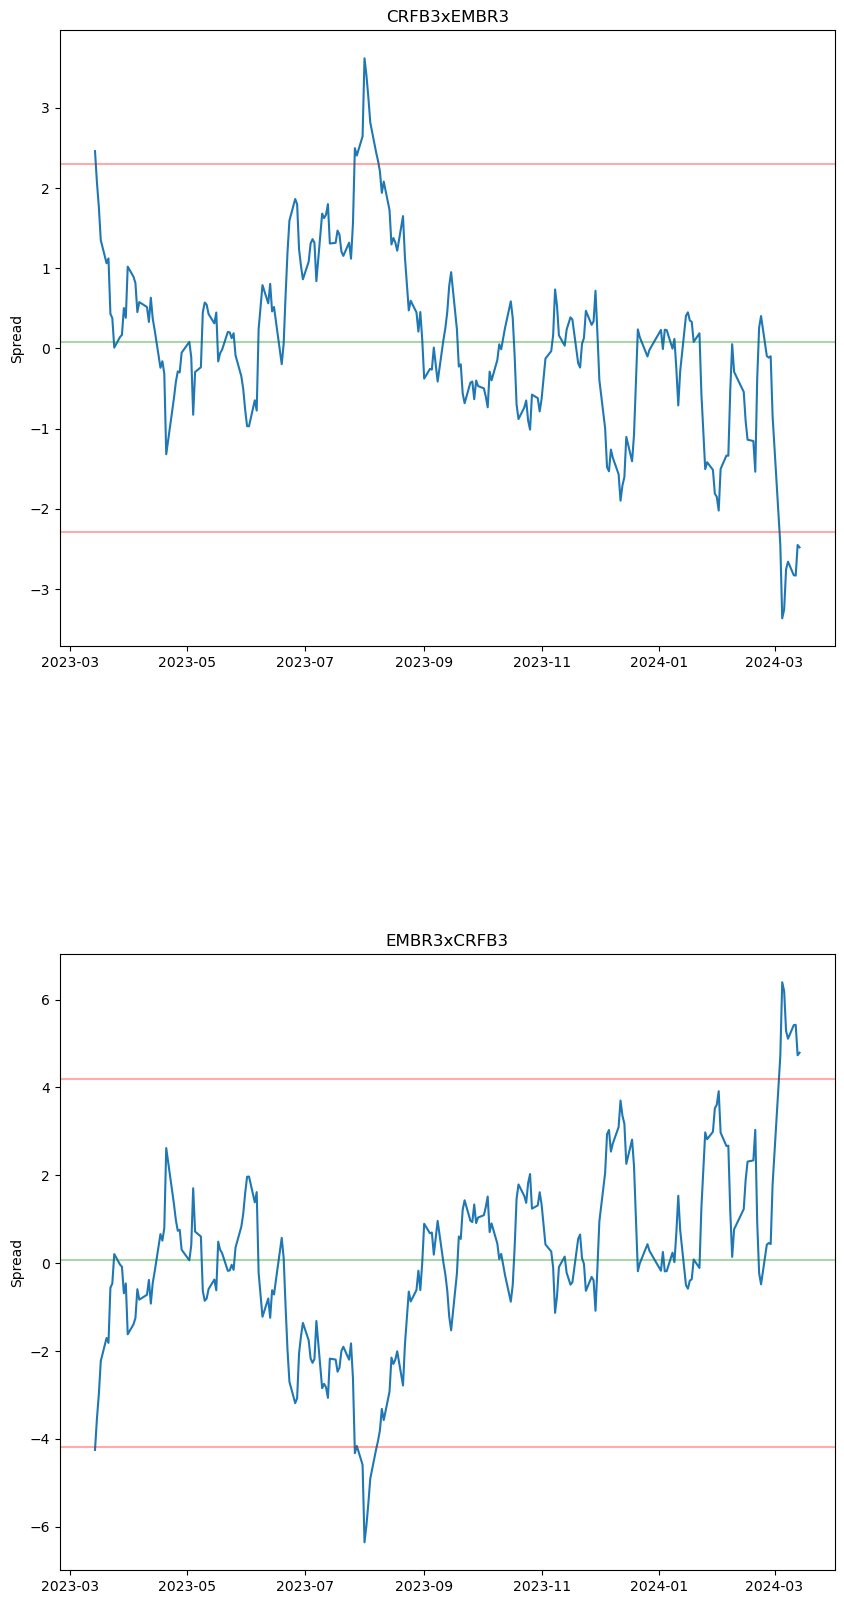

In [15]:
# Crie a figura e os eixos
fig, ax = plt.subplots(len(lista_entradas), 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)

# sobre os pares de entrada
for i, par in enumerate(lista_entradas):
    r = get_resid(par)
    sns.lineplot(x=df.index, y=r, ax=ax[i])
    ax[i].axhline(y=2*r.std(), color='r', alpha=0.33)
    ax[i].axhline(y=-2*r.std(), color='r', alpha=0.33)
    ax[i].axhline(y=r.mean(), color='g', alpha=0.33)
    ax[i].set_ylabel("Spread")
    ax[i].set_xlabel("")
    ax[i].set_title(par)

plt.show()